## Interval Analysis

In [21]:
!pip install tensorboardX


In [29]:
# !pip install tensorboardX

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import time
import matplotlib.pyplot as plt

from torchvision import datasets, transforms
# from tensorboardX import SummaryWriter

use_cuda = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 64

np.random.seed(42)
torch.manual_seed(42)


## Dataloaders
train_dataset = datasets.MNIST('mnist_data/', train=True, download=True, transform=transforms.Compose(
    [transforms.ToTensor()]
))
test_dataset = datasets.MNIST('mnist_data/', train=False, download=True, transform=transforms.Compose(
    [transforms.ToTensor()]
))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Simple NN. You can change this if you want. If you change it, mention the architectural details in your report.
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc = nn.Linear(28*28, 200)
        self.fc2 = nn.Linear(200,10)

    def forward(self, x):
        x = x.view((-1, 28*28))
        x = F.relu(self.fc(x))
        x = self.fc2(x)
        x = F.softmax(x, dim=-1) # added softmax for probabilities
        return x


class Normalize(nn.Module):
    def forward(self, x):
        return (x - 0.1307)/0.3081

# Add the data normalization as a first "layer" to the network
# this allows us to search for adverserial examples to the real image, rather than
# to the normalized image
model = nn.Sequential(Normalize(), Net())

model = model.to(device)
model.train()
print(model)


Sequential(
  (0): Normalize()
  (1): Net(
    (fc): Linear(in_features=784, out_features=200, bias=True)
    (fc2): Linear(in_features=200, out_features=10, bias=True)
  )
)


In [30]:
def train_model(model, num_epochs):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            images, labels = data
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.3f}')

def test_model(model):
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for data in test_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        print(f'Accuracy on images: {100 * correct / total}')

In [31]:
train_model(model, 15)
test_model(model)

Epoch 1/15, Loss: 2.012
Epoch 2/15, Loss: 1.729
Epoch 3/15, Loss: 1.627
Epoch 4/15, Loss: 1.596
Epoch 5/15, Loss: 1.582
Epoch 6/15, Loss: 1.572
Epoch 7/15, Loss: 1.566
Epoch 8/15, Loss: 1.561
Epoch 9/15, Loss: 1.557
Epoch 10/15, Loss: 1.553
Epoch 11/15, Loss: 1.550
Epoch 12/15, Loss: 1.547
Epoch 13/15, Loss: 1.545
Epoch 14/15, Loss: 1.542
Epoch 15/15, Loss: 1.540
Accuracy on images: 93.43


### Write the interval analysis for the simple model

In [14]:
## TODO: Write the interval analysis for the simple model
## you can use https://github.com/Zinoex/bound_propagation

In [25]:
!pip install bound-propagation

ε=0.010 -> 4959/10000 = 49.59% verified
ε=0.020 -> 530/10000 = 5.30% verified
ε=0.030 -> 20/10000 = 0.20% verified
ε=0.040 -> 0/10000 = 0.00% verified
ε=0.050 -> 0/10000 = 0.00% verified
ε=0.060 -> 0/10000 = 0.00% verified
ε=0.070 -> 0/10000 = 0.00% verified
ε=0.080 -> 0/10000 = 0.00% verified
ε=0.090 -> 0/10000 = 0.00% verified
ε=0.100 -> 0/10000 = 0.00% verified


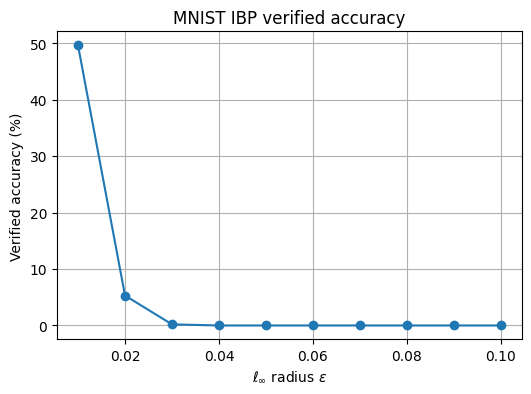

epsilon=0.010  verified_acc=49.59%
epsilon=0.020  verified_acc=5.30%
epsilon=0.030  verified_acc=0.20%
epsilon=0.040  verified_acc=0.00%
epsilon=0.050  verified_acc=0.00%
epsilon=0.060  verified_acc=0.00%
epsilon=0.070  verified_acc=0.00%
epsilon=0.080  verified_acc=0.00%
epsilon=0.090  verified_acc=0.00%
epsilon=0.100  verified_acc=0.00%


In [43]:
# interval verification for a trained MNIST model
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

# assume: model = nn.Sequential(Normalize(), Net()) already trained for 15 epochs
dev = next(model.parameters()).device
MEAN, STD = 0.1307, 0.3081

class SimpleNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(28*28, 200)
        self.fc2 = nn.Linear(200, 10)
    def forward(self, x):
        x = x.flatten(1)
        x = F.relu(self.fc(x))
        x = self.fcs(x)
        x = F.softmax(x, dim=-1)
        return x

# x = F.softmax(x, dim=-1)
# copy weights from the trained classifier body (assumes model = [Normalize(), Net()])
probe = SimpleNet().to(dev).eval()
with torch.no_grad():
    probe.fc.weight.copy_( model[1].fc.weight )
    probe.fc.bias.copy_( model[1].fc.bias )
    probe.fc2.weight.copy_(model[1].fc2.weight)
    probe.fc2.bias.copy_(model[1].fc2.bias)

@torch.inference_mode()
def affine_box(W, b, lo, hi):
    # For z = Wx + b with x ∈ [lo, hi],
    # split W = W⁺ + W⁻ where W⁺ = max(W, 0), W⁻ = min(W, 0)
    # Lower:  L = W⁺·lo + W⁻·hi + b
    # Upper:  U = W⁺·hi + W⁻·lo + b
    Wpos = torch.clamp(W, min=0)
    Wneg = torch.clamp(W, max=0)
    L = F.linear(lo, Wpos) + F.linear(hi, Wneg, b)
    U = F.linear(hi, Wpos) + F.linear(lo, Wneg, b)
    return L, U

@torch.inference_mode()
def bound_ibp(net, x, eps):
    B = x.size(0)
    # L∞ ball in pixel space with clipping: [x−ε, x+ε] ∩ [0,1]
    lo = torch.clamp(x - eps, 0.0, 1.0)
    hi = torch.clamp(x + eps, 0.0, 1.0)

    # apply training normalization: x̂ = (x−μ)/σ  (interval-wise)
    lo = (lo - MEAN) / STD
    hi = (hi - MEAN) / STD
    lo = lo.view(B, -1); hi = hi.view(B, -1)

    # affine layer 1 bounds
    w1, b1 = net.fc.weight, net.fc.bias
    lo, hi = affine_box(w1, b1, lo, hi)

    # ReLU interval: ReLU([L, U]) = [max(L, 0), max(U, 0)]
    lo = F.relu(lo)
    hi = F.relu(hi)

    # affine layer 2 bounds (logits)
    w2, b2 = net.fc2.weight, net.fc2.bias
    lo, hi = affine_box(w2, b2, lo, hi)
    return lo, hi

@torch.inference_mode()
def cert_mask(lo, hi, y):
    # Robust if:  L_y  >  max_{k≠y} U_k
    idx = torch.arange(y.size(0), device=y.device)
    Ly = lo[idx, y]
    mask_true = F.one_hot(y, hi.size(1)).bool()
    U_noty = hi.masked_fill(mask_true, float('-inf'))
    Umax = U_noty.max(1).values
    return Ly > Umax

@torch.inference_mode()
def sweep_verified_acc(net, loader, eps_values, restrict_to_clean=False):
    out = []
    model.eval()
    for e in eps_values:
        ok, tot = 0, 0
        for xb, yb in loader:
            xb, yb = xb.to(dev), yb.to(dev)

            if restrict_to_clean:
                # clean correctness filter (denominator becomes #clean-correct)
                pred = model(xb).argmax(1)  # softmax is allowed; argmax unchanged
                keep = pred == yb
                if keep.sum() == 0:
                    continue
                xb, yb = xb[keep], yb[keep]

            if xb.numel() == 0:
                continue

            lo, hi = bound_ibp(net, xb, float(e))
            good = cert_mask(lo, hi, yb)
            ok += int(good.sum().item())
            tot += xb.size(0) if restrict_to_clean else yb.size(0)

        acc = 100.0 * ok / tot if tot > 0 else 0.0
        print(f"ε={e:.3f} -> {ok}/{tot} = {acc:.2f}% verified")
        out.append(acc)
    return out

# 10 ε values linearly spaced in [0.01, 0.10], denominator = whole test set (as spec says)
eps_vals = torch.linspace(0.01, 0.10, steps=10).tolist()
curve = sweep_verified_acc(probe, test_loader, eps_vals, restrict_to_clean=False)

plt.figure(figsize=(6,4))
plt.plot(eps_vals, curve, marker='o')
plt.xlabel(r"$\ell_\infty$ radius $\epsilon$")
plt.ylabel("Verified accuracy (%)")
plt.title("MNIST IBP verified accuracy")
plt.grid(True)
plt.show()

for e, a in zip(eps_vals, curve):
    print(f"epsilon={e:.3f}  verified_acc={a:.2f}%")
